# FAQ

## I don't want to install GisMap on my computer

No worries, you can play with it using https://mybinder.org/.

For example:

- [A simple interface to display and save collaboration graphs](https://mybinder.org/v2/gh/balouf/gismap/HEAD?urlpath=%2Fdoc%2Ftree%2Fbinder%2Finteractive.ipynb)
- [Tutorial: Making LabMaps](https://mybinder.org/v2/gh/balouf/gismap/HEAD?urlpath=%2Fdoc%2Ftree%2Fdocs%2Ftutorials%2Flab_tutorial.ipynb)
- [Tutorial: Making EgoMaps](https://mybinder.org/v2/gh/balouf/gismap/HEAD?urlpath=%2Fdoc%2Ftree%2Fdocs%2Ftutorials%2Fegomap.ipynb)
- [Jupyter Lab instance with GisMap installed](https://mybinder.org/v2/gh/balouf/gismap/HEAD)

## LabMaps

### DB, Lab, Author, Maps... What does that mean?

The internal structure of GisMap interleaves simple concepts, like author, DB, publication, and lab.

- An `Author` is a researcher that has published papers. Internally, it's just a name.
- A `DB` is where the information comes from, like the [HAL portal](https://hal.science/) or
the [The DBLP Computer Science Bibliography](https://dblp.org/).
- A DB should provide a method to search authors and retrieve author's publications.
The results of these methods are lists of `DBAuthor` and `DBPublication`.
- A given author/publication can be present in multiple DBs, and quite frequently multiple times in the same DB.
GisMap uses `SourcedAuthor` and `SourcedPublication` to regroup multiple entries under a single banner.
- A `LabMap` is made of authors (`LabAuthor`, i.e. `SourcedAuthor` with additional metadata)
and publications (`SourcedPublication`).
- An `Egomap` is a special `LabMap` dedicated to one single researcher,
showing her co-authors and possibly their co-authors.

### Why are there errors in the authors / publications I get?

GisMap operates on real-life databases. The list of things that can go wrong is veeerrryyyy long. For example:

- One DB may be temporarily down (DBLP can have issues sometimes);
- Papers may be entered with bad author information;
- A paper may exist in multiple versions (e.g. report, conference, journal), possibly with different spellings;
- One given author may have multiple identity keys in the same DB;
- Multiple authors may share the same name (and sometimes identity key) in the same DB.

We do what we can to smooth things out automatically without any manual intervention, but sometimes it's not enough. However, 80% of the issues you may encounter can probably be solved by manual adjustment (see below).

### How are publications grouped together?

We use [Bag of Factors](https://balouf.github.io/bof/), a package base on [Joint Complexity](https://hal.science/hal-03129901).

If the titles are *close enough*, then we consider that it is the same paper. In case of multiple sources, one main source is selected (based on year, type, and other things).

:::note

We are aware that merging from title similarities has its flaws. But after comparing with other options (e.g. strict equality on title, authors, year, and possibly venue), we decided that it was a good compromise.

:::

### How to enter a researcher?

When a researcher is uniquely defined by her name, you can just enter that name, e.g.

In [1]:
from gismap.lab import LabAuthor

cc = LabAuthor("Céline Comte")
cc.auto_sources()
cc.sources

INFO:GisMap:LDB not found locally. Attempting to retrieve from GitHub...


INFO:GisMap:Fetching release info for: latest


INFO:GisMap:Downloading LDB from release v0.5.0 (0.86 GB)


LDB v0.5.0:   0%|          | 0.00/823M [00:00<?, ?B/s]

INFO:GisMap:4007038 authors indexed.


INFO:GisMap:LDB v0.5.0 successfully installed to /home/runner/.local/share/gismap/ldb.pkl.zst


[HALAuthor(name='Céline Comte', key='celine-comte'),
 LDBAuthor(name='Céline Comte', key='179/2173')]

However, sometimes, the name is ambiguous, and you may have multiple keys that corresponds to multiple authors.

In [2]:
fd = LabAuthor("François Durand")
fd.auto_sources()
fd.sources

INFO:GisMap:Multiple entries for François Durand in hal


[HALAuthor(name='François Durand', key='francois-durand'),
 HALAuthor(name='François Durand', key='francois-durand-dastes'),
 HALAuthor(name='François Durand', key='fradurand'),
 HALAuthor(name='François Durand', key='1254455', key_type='pid'),
 HALAuthor(name='François Durand', key='1370418', key_type='pid'),
 HALAuthor(name='François Durand', key='1296653', key_type='pid'),
 HALAuthor(name='François Durand', key='1551635', key_type='pid'),
 HALAuthor(name='François Durand', key='1524491', key_type='pid'),
 HALAuthor(name='François Durand', key='1276470', key_type='pid'),
 LDBAuthor(name='François Durand', key='38/11269')]

When that happens, you need to manually enter the desired keys.
This can be done by specifying the sources:

In [3]:
from gismap import HALAuthor, LDBAuthor

fd = LabAuthor.from_sources(
    [
        HALAuthor(name="François Durand", key="fradurand"),
        LDBAuthor(name="François Durand", key="38/11269"),
    ]
)
fd.sources

[HALAuthor(name='François Durand', key='fradurand'),
 LDBAuthor(name='François Durand', key='38/11269')]

For convenience, you can also enter keys in parentheses. For example, an exact equivalent of the above is:

In [4]:
fd = LabAuthor("François Durand (hal: fradurand, ldb: 38/11269)")
fd.sources

[HALAuthor(name='François Durand', key='fradurand'),
 LDBAuthor(name='François Durand', key='38/11269')]

:::note

- The parenthesis notation can also be used to specify other metadata (URL, image, group) with the same "key: value, ..."format
- For proper parsing, a name should contain no parenthesis, a key should not contain "," or ":", and a value should not contain ","
- You can enter multiple keys for the same DB, e.g. "My name (hal: key1, hal: key2)"

:::

In [5]:
dummy = LabAuthor(
    "My Name(img: https://my.url.img, group:me,url:https://mysite.org,hal:key1,hal:123456,dblp:toto,badkey:hello,no_colon_separator)"
)
print(dummy.metadata)
print(dummy.sources)

AuthorMetadata(url='https://mysite.org', img='https://my.url.img', group='me')
[HALAuthor(name='My Name', key='key1'), HALAuthor(name='My Name', key='123456', key_type='pid'), DBLPAuthor(name='My Name', key='toto')]


### There is a publication that should not be there in my LabMap

The first thing to check is if the publication has one external author with the same name that one of the lab's authors.
If that is the case, try to manually specify the sources of the author to avoid this.


Another possibility (e.g. the DB does not distinguish the internal and external authors) is to add a manual filter to discard the outsider. For example, the following publication is a DBLP false positive.

In [6]:
fd = LabAuthor("François Durand (dblp: 38/11269)")
pubs = fd.get_publications()
print(len(pubs))
[p.title for p in pubs.values() if "Horse Locomotion" in p.title]

18


['Detection of Horse Locomotion Modifications Due to Training with Inertial Measurement Units: A Proof-of-Concept.']

It will associate wrong co-authors. The solution is then to add a *publication filter*.

In [7]:
no_horse = lambda p: "Horse Locomotion" not in p.title
pubs = fd.get_publications(selector=no_horse)
print(len(pubs))
[p.title for p in pubs.values() if "Horse Locomotion" in p.title]

17


[]

### There is a publication that should be there in my LabMap

If a publication exists when you check it with the `get_publications` method of a `LabAuthor`, but is not registered in the lab publications, that probably means that the publication has been rejected by one the default filter.

- `LabMap` objects store a list of filters in the attribute `publication_selectors`. For a publication to be stored, all filters must return `True`.
- Default filters:
  - There should be no more than 9 authors. In my research field, collegial papers are relatively rare and most of the time they stem from a pollution from other fields where 100+ authors are entered at once with a large risk of error.
  - The title should have at least 2 words.
  - The title should not contain *taboo* words like *Editorial*, *Foreword*, *Brief Announcement*, *Preface*.

Feel free to change the existing filters or add new ones to adapt to your needs.

For example, to build the EgoMap of François Durand, taking account some specificities:

Star metadata: 0it [00:00, ?it/s]

Star publications:   0%|          | 0/1 [00:00<?, ?it/s]

Planets:   0%|          | 0/25 [00:00<?, ?it/s]

Moons:   0%|          | 0/4 [00:00<?, ?it/s]


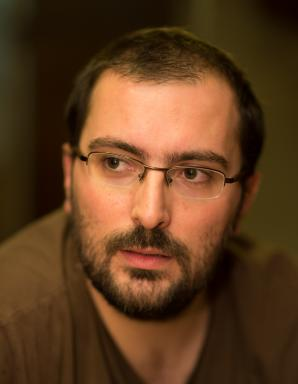
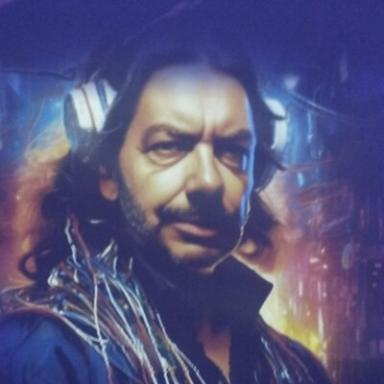
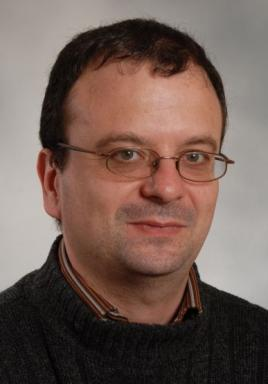
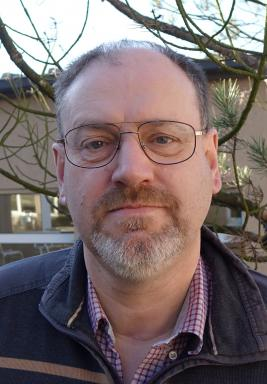

In [8]:
from gismap.lab import EgoMap
from gismap.lab.filters import publication_taboo_filter, publication_oneword_filter

fd = EgoMap("François Durand (hal: fradurand, dblp: 38/11269)")
fd.publication_selectors = [
    publication_taboo_filter(),
    publication_oneword_filter(n_min=4),
    no_horse,
]
fd.build(target=30)
fd.show_html()

### How to specify the DBs to use?

For `LabMap` (including `EgoMap`), you can specify a `dbs` parameter. It can be a string or a DB subclass,
or a list of strings or DB subclasses.

For `SourcedAuthor`/`LabAuthor`, you can specify `dbs` for the `auto_sources` method.

## Graphical representation

### Stars, planets, moons, comets?

The *Maps*, i.e., the graphical representation of the collaboration graph, use vocabulary borrowed from astronomy.

- **Stars** and **Planets**: For EgoMaps, you are the *star*, e.g., the center of your own universe. *Planets* are people that revolve around you, i.e., your co-authors.
- **Moons**: A *moon* is a researcher connected to a planet or a lab.
- **Comets**: A comet has no direct link with other displayed entities.

### I don't want images!

By default, GisMap will retrieve pictures from the DB if it is available. Some `Lab` also fetch image data.

If you don't want any image in your map, the best is probably to remove them from the authors' metadata:

In [9]:
for author in fd.authors.values():
    author.metadata.img = None
fd.show_html()

### The graph is spinning forever

It's a glitch in the physical engine that can happen from time to time. Usually, hitting the `redraw()` button (upper left corner) does the trick.

### It's too small, I cannot see anything

Sadly, for very large graphs, the quantity of information to embed is just too important. However, a few tricks can help a bit:

- Use `Full Screen` (lower right corner);
- Zoom inside the graph, e.g. using the mouse wheel;
- Move nodes around / use the `Redraw()` button;
- Remind that full names appear when you hover nodes, it can help navigate when you know the people.

### How to embed a Map on my website?

- For a simple and static embedding, you can use [Binder to manually generate the Map](https://mybinder.org/v2/gh/balouf/gismap/HEAD?urlpath=%2Fdoc%2Ftree%2Fbinder%2Finteractive.ipynb).
- For something more advanced, it is recommended to write a Python script that generates the Map.

## databases

### What databases are available, and what are their advantages?

| Database | Pros                                        | Cons                                              |
|----------|---------------------------------------------|---------------------------------------------------|
| HAL      | Fast; Rich metadata (e.g. abstracts)        | France-based research only; Errors and gaps exist |
| DBLP     | Highly accurate; Unified venue names        | Computer Science only; Very slow                  |
| LDB      | Fast; Highly accurate; Unified venue names  | Computer Science only; 3GB RAM recommended        |

### Why doesn’t GisMap use database X?

I wanted to rely on publication databases that:

- have a public API;
- are relatively clean and up to date;
- do not require an API key.

To date, only HAL and DBLP seem to meet these specifications.

That said, GisMap is designed to be multi-source, so if a contributor wants to add an interface to another database (Google Scholar, ORCID, ...), they are encouraged to write it and make a PR!